# Importing the Modules

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Install Kaggle API
!pip install -q kaggle

# Upload kaggle.json file from your local machine
from google.colab import files
files.upload()

# Create Kaggle directory
!mkdir ~/.kaggle

# Move kaggle.json to the Kaggle directory
!cp kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d soumikrakshit/anime-faces

# Unzip the dataset
!unzip anime-faces.zip


Streaming output truncated to the last 5000 lines.
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/data/552.png       

# Data Preperation

In [4]:
train_directory = 'data'

dataset = keras.preprocessing.image_dataset_from_directory(
    train_directory, 
    label_mode = None, 
    image_size=(64, 64), 
    batch_size=32, 
    shuffle=True

    ).map(lambda x: x/255.0)

Found 43102 files belonging to 1 classes.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Modelling

In [5]:
#Starting Noise Dimension
LATENT_DIM = 128

generator = keras.Sequential([
    layers.Input(shape=(LATENT_DIM)),
    #Taking the noise vector to a 8x8 image with 128 channel
    layers.Dense(8*8*128),
    layers.Reshape((8, 8, 128)),

    #Generator image need to larger so we use ConvTranspose istead of Conv
    layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(0.2),

    layers.Conv2DTranspose(512, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(0.2),

    #This Conv layer doesn't multiply the image size
    layers.Conv2D(3, kernel_size = 5, padding='same', activation='sigmoid'),
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)       0

# Discriminator

In [6]:
discriminator = keras.Sequential([
    keras.Input(shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(0.2),

    layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(0.2),

    layers.Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'),
    layers.LeakyReLU(0.2),

    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'sigmoid'),
    ])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

# Training and Optimization

In [7]:
loss_fn = keras.losses.BinaryCrossentropy(from_logits= True)

# Optimizer

In [8]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)

In [9]:
EPOCHS = 100

# Training Function

In [18]:
def train(dataset, epochs):
    print("Training Started...")
    for epoch in range(epochs):
        for idx, real in enumerate(tqdm(dataset)):
            batch_size = real.shape[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, LATENT_DIM))

            #Generating Fake Image
            with tf.GradientTape() as gen_tape:
                fake = generator(random_latent_vectors)

            with tf.GradientTape() as disc_tape:
                #Training Discriminator: max y*log(D(x)) + (1-y)*log(1 - D(G(z))), Here we are sending in y as 1 to get the log(D(x))
                loss_disc_real = loss_fn(tf.ones((batch_size, 1)), discriminator(real))
                loss_disc_fake = loss_fn(tf.zeros((batch_size, 1)), discriminator(fake))

                loss_disc = (loss_disc_fake + loss_disc_real) /2
            
            #Calculating the Gradient
            grads = disc_tape.gradient(loss_disc, discriminator.trainable_weights)

            #Updating the Discriminator
            opt_disc.apply_gradients(
                zip(grads, discriminator.trainable_weights)
                )

            ### Train the generator: min log(1-D(G(z))) it has saturation problem so we use log(D(G(z))) instead
            with tf.GradientTape() as gen_tape:
                fake = generator(random_latent_vectors)
                output = discriminator(fake)
                loss_gen = loss_fn(tf.ones(batch_size, 1), output)
            
            grads = gen_tape.gradient(loss_gen, generator.trainable_weights)

            opt_gen.apply_gradients(
                zip(grads, generator.trainable_weights)
                )
        # Display a generated image
        img = keras.preprocessing.image.array_to_img(fake[0])
        img.save(f"generated_images/generated_img{epoch}_{idx}_.png")
        
        plt.imshow(img)
        plt.show()
        
        print("Epoch {}, D_loss: {}, G_loss: {}".format(epoch+1, loss_disc, loss_gen))
    return


Training Started...


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


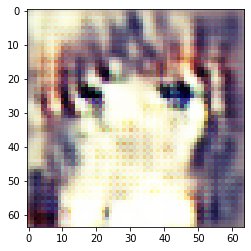

Epoch 1, D_loss: 0.676852822303772, G_loss: 0.5142067074775696


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


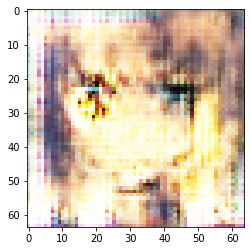

Epoch 2, D_loss: 1.0298656225204468, G_loss: 0.43455296754837036


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


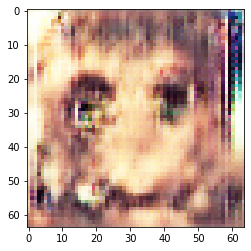

Epoch 3, D_loss: 0.5557079315185547, G_loss: 0.5229244828224182


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


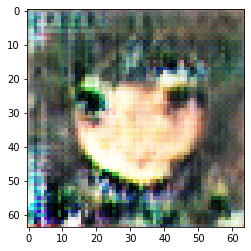

Epoch 4, D_loss: 0.47495925426483154, G_loss: 0.5455191731452942


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


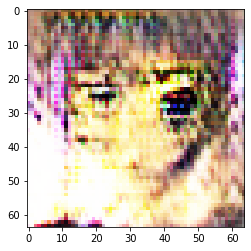

Epoch 5, D_loss: 0.7622156143188477, G_loss: 0.5210431814193726


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


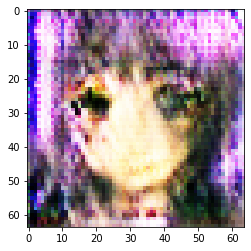

Epoch 6, D_loss: 0.6762560606002808, G_loss: 0.4923937916755676


100%|██████████| 1347/1347 [07:19<00:00,  3.06it/s]


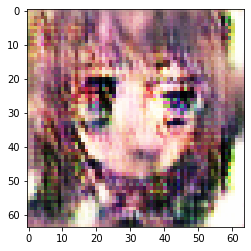

Epoch 7, D_loss: 0.7625064253807068, G_loss: 0.4769650101661682


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


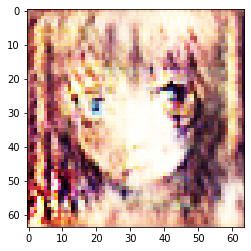

Epoch 8, D_loss: 0.6560918092727661, G_loss: 0.4989968240261078


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


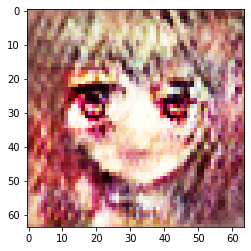

Epoch 9, D_loss: 0.5125258564949036, G_loss: 0.5647546648979187


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


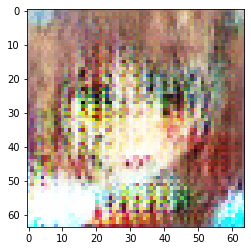

Epoch 10, D_loss: 0.8052589893341064, G_loss: 0.5287391543388367


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


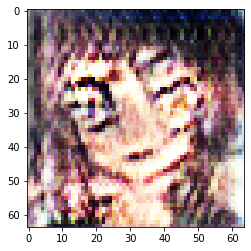

Epoch 11, D_loss: 0.7354798316955566, G_loss: 0.49555766582489014


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


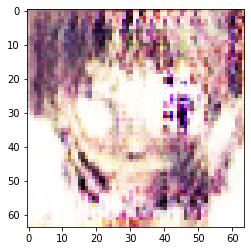

Epoch 12, D_loss: 0.6074901819229126, G_loss: 0.4942316710948944


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


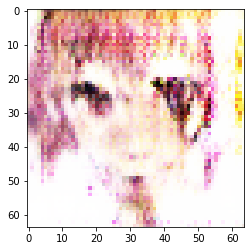

Epoch 13, D_loss: 0.6841390132904053, G_loss: 0.47668877243995667


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


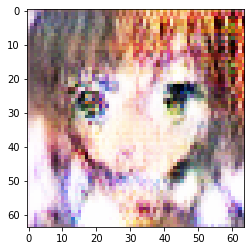

Epoch 14, D_loss: 0.7118901014328003, G_loss: 0.5119249820709229


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


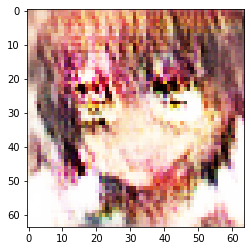

Epoch 15, D_loss: 0.4925715923309326, G_loss: 0.5359594821929932


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


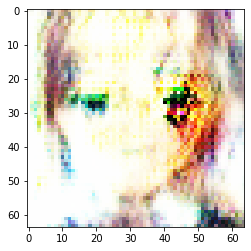

Epoch 16, D_loss: 0.8219499588012695, G_loss: 0.4718743860721588


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


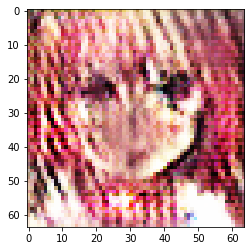

Epoch 17, D_loss: 0.8303263187408447, G_loss: 0.4653456509113312


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


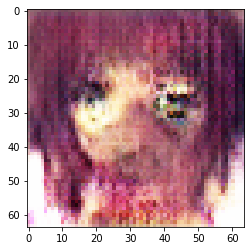

Epoch 18, D_loss: 0.5930494070053101, G_loss: 0.49348941445350647


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


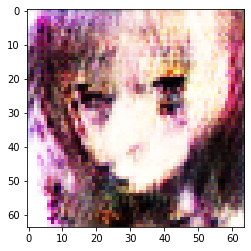

Epoch 19, D_loss: 0.6431785821914673, G_loss: 0.5277459621429443


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


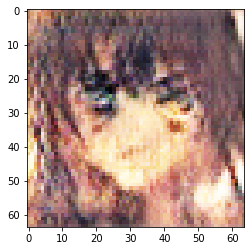

Epoch 20, D_loss: 0.7391037940979004, G_loss: 0.462433397769928


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


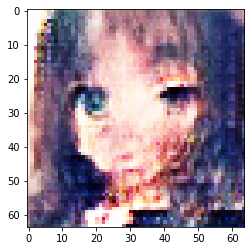

Epoch 21, D_loss: 0.6949708461761475, G_loss: 0.4686744511127472


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


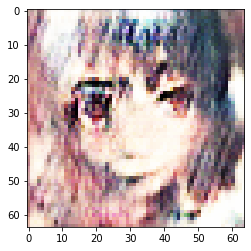

Epoch 22, D_loss: 0.5636175870895386, G_loss: 0.5397665500640869


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


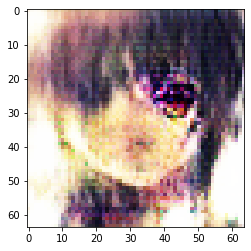

Epoch 23, D_loss: 0.7972727417945862, G_loss: 0.4526483416557312


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


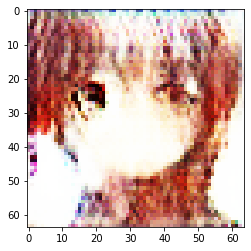

Epoch 24, D_loss: 0.4453999996185303, G_loss: 0.5450628995895386


100%|██████████| 1347/1347 [07:19<00:00,  3.06it/s]


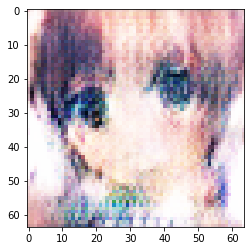

Epoch 25, D_loss: 0.7026214003562927, G_loss: 0.47754669189453125


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


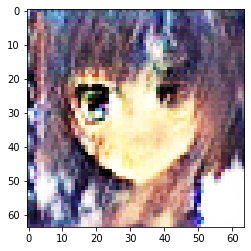

Epoch 26, D_loss: 0.6733146905899048, G_loss: 0.47379112243652344


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


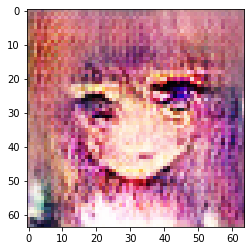

Epoch 27, D_loss: 0.5151144862174988, G_loss: 0.5292564034461975


100%|██████████| 1347/1347 [07:19<00:00,  3.06it/s]


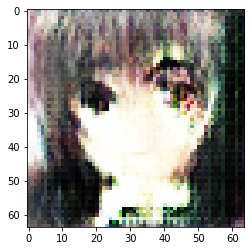

Epoch 28, D_loss: 0.735724925994873, G_loss: 0.4623430371284485


100%|██████████| 1347/1347 [07:19<00:00,  3.06it/s]


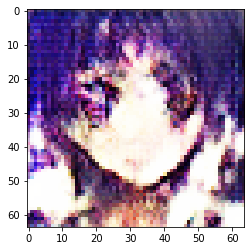

Epoch 29, D_loss: 0.6367068886756897, G_loss: 0.5210509896278381


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


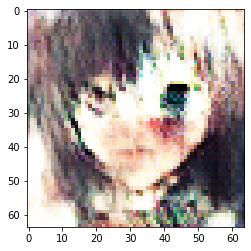

Epoch 30, D_loss: 0.6461355686187744, G_loss: 0.5004213452339172


100%|██████████| 1347/1347 [07:19<00:00,  3.06it/s]


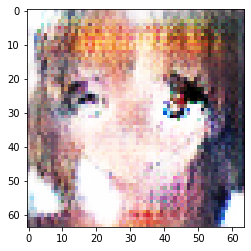

Epoch 31, D_loss: 0.7151807546615601, G_loss: 0.5057218074798584


100%|██████████| 1347/1347 [07:20<00:00,  3.06it/s]


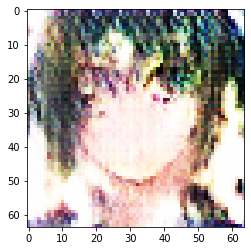

Epoch 32, D_loss: 0.7461565732955933, G_loss: 0.498277485370636


100%|██████████| 1347/1347 [07:21<00:00,  3.05it/s]


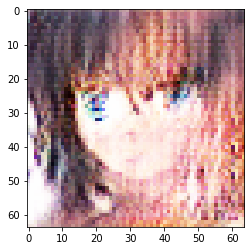

Epoch 33, D_loss: 0.7462385892868042, G_loss: 0.48055732250213623


 57%|█████▋    | 764/1347 [04:09<03:09,  3.08it/s]

In [ ]:
train(dataset, EPOCHS)